In [1]:
import os, glob
import cupy as cp
from cupyx.scipy import ndimage as cpx_ndimage  # Import CuPy's GPU ndimage module
import numpy as np
import scipy as sp
import tifffile as tiff
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.widgets import Slider
from matplotlib import animation, rc
rc('animation', html='jshtml')
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128             # to set a higher threshold for maximum .gif size that we can embed here
import glob; import cv2
from scipy import ndimage, misc
from scipy.stats import chi2
from scipy.ndimage import maximum_filter, label, find_objects
from sklearn.decomposition import PCA

from scipy.optimize import curve_fit
from skimage.feature import peak_local_max
from natsort import natsorted
import scipy.io as sio
import skimage.io as io
from skimage.exposure import adjust_gamma
import imageio
import multiprocessing as mp
import trackpy as tp
import ipywidgets as widgets
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)     # ignore warnings for specific matplotlib commands which will be outdated soon
from IPython.display import display, Image


In [2]:
def convert_to_code_path(windows_path):
    # Replace each single backslash with a double backslash
    return windows_path.replace("\\", "\\\\")

## Loading the demonstrative movies for anisotropy study (Flat or Ridges)

In [83]:
# Address where all raw images are (choose 0 for 'flat', 1 for 'ridges')
 
surface = 1

if surface == 0:
    data_folder = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div2\control_div2_glass_2019_01_23_div2cortex_C1_timelapse1_2secPerTP_5min');
    image_path = data_folder+'\\'+'div2cortex_C1_timelapse1_2secPerTP_5min_jttr_blch_corr.tiff'
else:
    data_folder = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div2\ridges_19_02_11_C2_ridges_timelapse1');
    image_path = data_folder+'\\'+'ridges_19_02_11_C2_ridges_timelapse1_jttr_blch_corr.tiff'

resolution = 2.7778   #px./um
frame_interval = 2.0 #s/frame.

df = pd.read_csv(data_folder+"\\tp_trajectories_final.csv")
img = tiff.imread(image_path) 
im_mean = np.mean(img,axis=0)

## Quantifying Anisotropy
### Plotting shifted trajectories

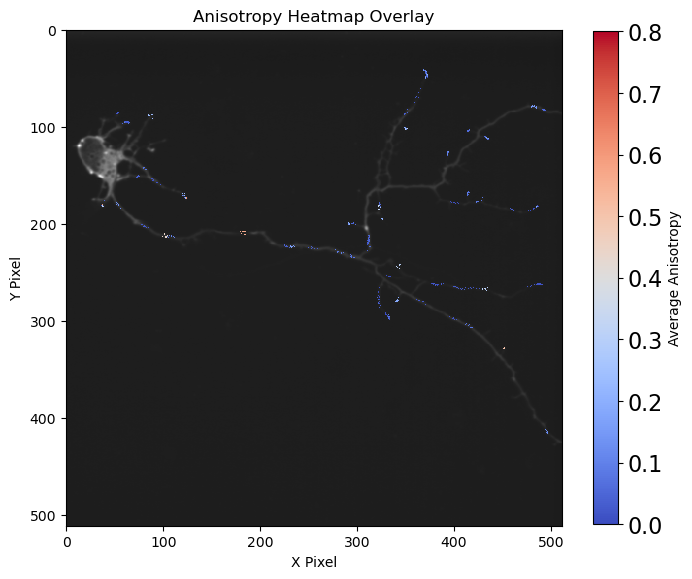

In [76]:
def plot_anisotropy_heatmap(df, image, image_shape, frac_to_analyze=1.0):
    """
    Plots a heatmap of the average anisotropy at each pixel location based on particle trajectories,
    and overlays it on the provided image.

    Parameters:
        df (pd.DataFrame): DataFrame with 'particle', 'x', and 'y' columns.
        image (ndarray): The base image on which to overlay the heatmap.
        image_shape (tuple): The shape of the image (height, width).
        frac_to_analyze (float): Fraction of the total particles to visualize (default is 1.0, i.e., all).
    """
    # Create a 2D array to store the sum of anisotropy values for each pixel
    anisotropy_map = np.zeros(image_shape)
    
    # Create a 2D array to store the count of occurrences for each pixel
    count_map = np.zeros(image_shape)

    # Randomly select a fraction of the particles to visualize
    particles = df['particle'].unique()
    selected_particles = np.random.choice(particles, size=int(len(particles) * frac_to_analyze), replace=False)

    for particle, group in df.groupby("particle"):
        # Apply the fraction visualization filter
        if particle not in selected_particles:
            continue
        
        # Extract x, y coordinates for the current particle
        x, y = group["x"].values, group["y"].values  
        
        # Calculate the anisotropy of the trajectory (using PCA or another method)
        pca = PCA(n_components=2)
        pca.fit(np.column_stack((x, y)))
        
        # Calculate anisotropy as the smaller eigenvalue divided by the larger eigenvalue
        anisotropy_ratio = min(pca.explained_variance_ratio_) / max(pca.explained_variance_ratio_)  # Smaller / Larger eigenvalue ratio
        
        # Ensure anisotropy ratio is between 0 and 1
        anisotropy_ratio = min(max(anisotropy_ratio, 0), 1)

        # Assign the anisotropy value to all points on the trajectory
        for i in range(len(x)):
            pixel_x = int(x[i])  # Ensure integer pixel coordinates
            pixel_y = int(y[i])  # Ensure integer pixel coordinates

            # Ensure the pixel coordinates are within bounds
            if 0 <= pixel_x < image_shape[1] and 0 <= pixel_y < image_shape[0]:
                anisotropy_map[pixel_y, pixel_x] += anisotropy_ratio
                count_map[pixel_y, pixel_x] += 1

    # Compute the average anisotropy for each pixel, avoiding division by zero
    avg_anisotropy_map = np.divide(anisotropy_map, count_map, where=(count_map != 0))  # Avoid division by zero

    # Set pixels with no data to NaN
    avg_anisotropy_map[count_map == 0] = np.nan

    # Plot the base image
    plt.figure(figsize=(8, 8))
    plt.imshow(im_mean, cmap='gray', interpolation='nearest', alpha=0.9, origin='lower')  # Show base image (grayscale)
    
    # Overlay the anisotropy heatmap with transparency (alpha)
    plt.imshow(avg_anisotropy_map, cmap='coolwarm', interpolation='nearest', alpha=1.0, origin='upper', vmin = 0.0, vmax = 0.8)  # Overlay heatmap with a more visible colormap
    
    # Add colorbar and labels
    cbar = plt.colorbar(label='Average Anisotropy', shrink=0.8)
    
    # Increase tick size and label size of the colorbar
    cbar.ax.tick_params(labelsize=16)  # Adjust this value for tick label size
    cbar.ax.tick_params(axis='y', labelsize=16)  # You can also specify the axis (y in this case)
    
    # Title and labels
    plt.title('Anisotropy Heatmap Overlay')
    plt.xlabel('X Pixel')
    plt.ylabel('Y Pixel')
    plt.grid(False)
    
    plt.savefig(data_folder+'\\anisotropy_heatmap.svg', format='svg', bbox_inches='tight')
    plt.show()

# Example usage:
image_shape = im_mean.shape  # Get the shape of the image
plot_anisotropy_heatmap(df, im_mean, image_shape, frac_to_analyze=1.0)


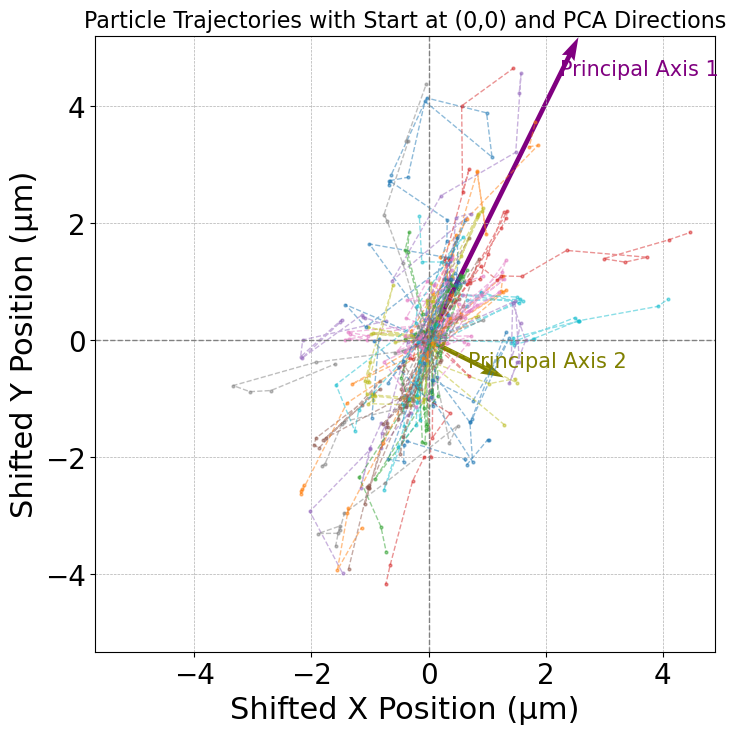

In [84]:
def plot_shifted_trajectories(df, frac_to_analyze=1.0):
    """
    Plots particle trajectories after shifting their starting position to the origin (0,0),
    rescaling the coordinates to micrometers, and reflecting them along the y-axis.
    PCA directions are also shown.
    
    Parameters:
        df (pd.DataFrame): DataFrame with 'particle', 'x', and 'y' columns.
        frac_to_analyze (float): Fraction of the total particles to visualize (default is 1.0, i.e., all).
    """
    plt.figure(figsize=(8, 8))

    # Collect all coordinates for PCA (all particles)
    all_coords = []

    # Randomly select a fraction of the particles to visualize
    particles = df['particle'].unique()
    selected_particles = np.random.choice(particles, size=int(len(particles) * frac_to_analyze), replace=False)

    for particle, group in df.groupby("particle"):
        # Apply the fraction visualization filter
        if particle not in selected_particles:
            continue
        
        # Extract the coordinates for the current particle and rescale
        x, y = group["x"].values / resolution, group["y"].values / resolution  # Convert px to µm

        # Shift so that the first position is at (0,0)
        x_shifted = x - x[0]
        y_shifted = y - y[0]

        # Reflect the trajectories with respect to the y-axis
        x_shifted = -x_shifted

        # Plot the trajectory
        plt.plot(x_shifted, y_shifted, marker="o", linestyle="--", markersize=2, linewidth=1, alpha=0.5, label=f"Particle {particle}")

        # Collect coordinates for PCA (still in list form)
        all_coords.append(np.column_stack((x_shifted, y_shifted)))

    # Stack all coordinates for PCA (using full set of coordinates, not just the selected ones)
    if all_coords:  # Check if list is not empty
        all_coords = np.vstack(all_coords)

        # Apply PCA to the coordinates
        pca = PCA(n_components=2)
        pca.fit(all_coords)

        # Get the eigenvalues (variances) of the PCA components
        eigenvalues = pca.explained_variance_
        
        # Scale the PCA directions by the eigenvalues
        pca_direction_1 = pca.components_[0] * eigenvalues[0]  # Scale by the first eigenvalue
        pca_direction_2 = pca.components_[1] * eigenvalues[1]  # Scale by the second eigenvalue

        # Plot PCA directions (arrows)
        plt.quiver(0, 0, pca_direction_1[0], pca_direction_1[1], angles='xy', scale_units='xy', scale=0.35, color='purple', linewidth=2, label="PCA Direction 1")
        plt.quiver(0, 0, pca_direction_2[0], pca_direction_2[1], angles='xy', scale_units='xy', scale=0.35, color='olive', linewidth=2, label="PCA Direction 2")

    # Formatting the plot
    plt.axhline(0, color="gray", linestyle="--", linewidth=1)  # Reference line at y=0
    plt.axvline(0, color="gray", linestyle="--", linewidth=1)  # Reference line at x=0
    plt.xlabel("Shifted X Position (µm)", fontsize=22)
    plt.ylabel("Shifted Y Position (µm)", fontsize=22)
    plt.title("Particle Trajectories with Start at (0,0) and PCA Directions", fontsize=16)
    plt.axis("equal")  # Keep aspect ratio square

    # Apply the limits after setting axis equal
    plt.xlim([-5.0, 4.2])
    plt.ylim([-5.32, 5.2])

    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)

    plt.text(pca_direction_1[0] * 2.5, pca_direction_1[1] * 2.5, "Principal Axis 1", color="purple", fontsize=15)
    plt.text(pca_direction_2[0] * 1.5, pca_direction_2[1] * 2.1, "Principal Axis 2", color="olive", fontsize=15)

    # Show the plot
    plt.savefig(data_folder+'\\shifted_trajectories_with_pca.svg', format='svg', bbox_inches='tight')
    plt.show()

# Example Usage
plot_shifted_trajectories(df, frac_to_analyze=1.0)  # Visualize 100% of particles


### Plotting example anisotropy ratio distribution

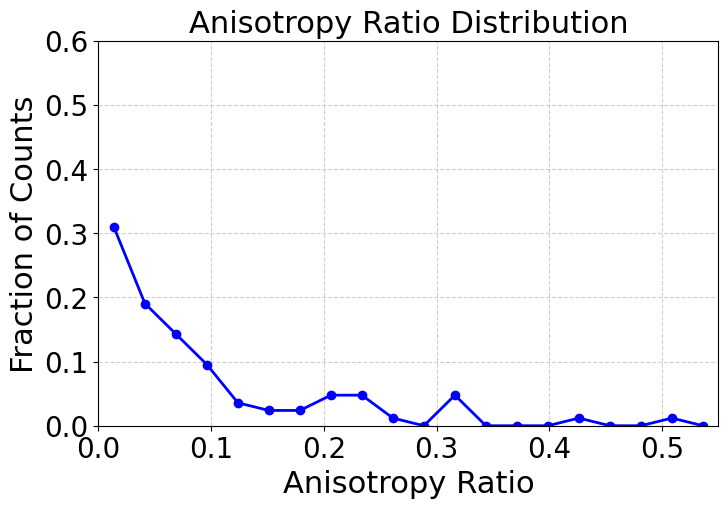

In [158]:
def compute_anisotropy_ratio(x, y):
    """
    Compute the anisotropy ratio (λ2 / λ1) from the covariance matrix of a trajectory.
    """
    x_shifted = x - x[0]
    y_shifted = y - y[0]
    
    cov_matrix = np.cov(np.vstack((x_shifted, y_shifted)))
    eigenvalues, _ = np.linalg.eig(cov_matrix)
    
    lambda_1, lambda_2 = np.sort(eigenvalues)[::-1]  # Sort in descending order
    return lambda_2 / lambda_1  # Anisotropy ratio

def get_anisotropy_ratios(df, resolution):
    """
    Compute anisotropy ratios for all particle trajectories in the DataFrame.
    """
    ratios = []
    for particle, group in df.groupby("particle"):
        x, y = group["x"].values / resolution, group["y"].values / resolution
        ratio = compute_anisotropy_ratio(x, y)
        ratios.append(ratio)
    return np.array(ratios)

def plot_anisotropy_distribution(ratios):
    """
    Plot the fraction of counts for anisotropy ratios as a line plot.
    """
    bins = 20
    range_min, range_max = 0, 0.55
    
    hist_counts, bin_edges = np.histogram(ratios, bins=bins, range=(range_min, range_max), density=False)
    fraction_counts = hist_counts / sum(hist_counts)  # Normalize to fraction
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Get bin centers
    
    # Plot as a line plot
    plt.figure(figsize=(8, 5))
    plt.plot(bin_centers, fraction_counts, marker='o', linestyle='-', color='b', linewidth=2)
    plt.xlabel("Anisotropy Ratio", fontsize=22)
    plt.ylabel("Fraction of Counts", fontsize=22)
    plt.title("Anisotropy Ratio Distribution", fontsize=22)
    plt.xlim(range_min, range_max)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)
    plt.ylim([0, 0.6])
    plt.savefig(data_folder+'\\anisotropy_distribution.svg', format='svg', bbox_inches='tight')
    plt.show()

# Example usage
anisotropy_ratios = get_anisotropy_ratios(df, resolution)
plot_anisotropy_distribution(anisotropy_ratios)


## Burstiness of tracks

### Considering only newly appeared tracks

In [374]:
# Convert data folder based on the surface variable
surface = 1

if surface == 0:
    data_folder = r'E:\Spandan\2D_Neurons_Paper\Glass\div2\control_div2_glass_2019_06_24_cortical_div2_timelapse1'
else:
    data_folder = r'E:\Spandan\2D_Neurons_Paper\Ridges\div3\ridges_2021_04_16_well2_timelapse1_PFS'

# Read the CSV file containing trajectory data
df = pd.read_csv(os.path.join(data_folder, "tp_trajectories_final.csv"))

# Search for the .tiff file that ends with '_jttr_blch_corr.tiff' in the data folder
tiff_files = glob.glob(os.path.join(data_folder, '*_jttr_blch_corr.tiff'))

# Check if the file exists
if tiff_files:
    # Assuming there's only one such file, you can use the first match
    tiff_file_path = tiff_files[0]
    
    # Read the tiff file using tifffile to get the number of frames
    with tiff.TiffFile(tiff_file_path) as tif:
        num_frames = len(tif.pages)  # Each page corresponds to a frame
        
    print(f"Number of frames in the tiff file: {num_frames}")
else:
    print("No '_jttr_blch_corr.tiff' file found in the folder.")


Number of frames in the tiff file: 151


In [375]:
def calculate_burstiness_metrics(trajectories, number_frames):
    """
    Calculate both autocorrelation and Coefficient of Variation (CV) for first particle appearances,
    and also return an array storing the number of new trajectories for each frame, including frames with no new tracks.
    
    Parameters:
    trajectories (pd.DataFrame): DataFrame containing particle trajectories with columns ['particle', 'frame']
    
    Returns:
    dict: A dictionary containing the autocorrelation, CV values, and the array of new trajectory counts for each frame
    """
    
    # Step 1: Get the first appearance frame for each particle
    first_appearances = trajectories.groupby('particle')['frame'].min()

    # Step 2: Count how many first appearances occur in each frame
    first_appearance_counts = first_appearances.value_counts().sort_index()

    # Step 3: Ensure that all frames are represented, even those with no first appearance
    # Use the maximum frame value from the dataset as the final frame
    max_frame = trajectories['frame'].max()
    all_frames = np.arange(0,number_frames)
    
    # Initialize a Series with zeros for all frames
    first_appearance_counts_full = pd.Series(0, index=all_frames)
    
    # Fill the counts for frames with first appearances
    first_appearance_counts_full.update(first_appearance_counts)

    # Convert to array (with all frames and zeros where no new trajectories appear)
    trajectory_counts_per_frame = first_appearance_counts_full.values

    # Step 4: Calculate the autocorrelation for first appearance counts
    if len(trajectory_counts_per_frame) > 1:
        autocorr_first_appearances = np.corrcoef(trajectory_counts_per_frame[:-1], trajectory_counts_per_frame[1:])[0, 1]
    else:
        autocorr_first_appearances = np.nan  # Not enough data for autocorrelation

    # Step 5: Calculate the Coefficient of Variation (CV) for first appearance counts
    mean_first_appearances = first_appearance_counts_full.mean()
    std_first_appearances = first_appearance_counts_full.std()
    
    if mean_first_appearances != 0:
        cv_first_appearances = std_first_appearances / mean_first_appearances
    else:
        cv_first_appearances = np.nan  # Avoid division by zero if mean is zero

    return {
        "Autocorrelation for First Appearances": autocorr_first_appearances,
        "Coefficient of Variation for First Appearances": cv_first_appearances,
        "Trajectory Counts per Frame": trajectory_counts_per_frame  # Array of new trajectories per frame
    }

# Example usage:
metrics = calculate_burstiness_metrics(df, num_frames)


### Plotting # of new tracks vs time

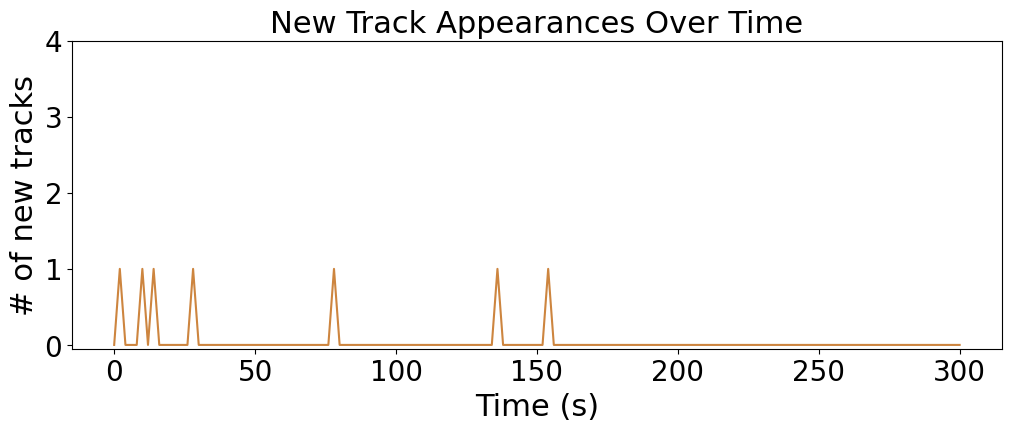

In [376]:
# Convert frame numbers to real time (seconds)
new_trajectory_counts = metrics["Trajectory Counts per Frame"]
time_axis = np.arange(0,num_frames,1) * 2  # Multiply by frame interval

# Plot the first appearance counts with time as x-axis
plt.figure(figsize=(12, 4))
# plt.scatter(time_axis, new_trajectory_counts, color="tan", alpha=0.7, edgecolor="black", linewidth=1, s=80, label='First Appearances')
plt.plot(time_axis, new_trajectory_counts, linestyle="-", color="peru")

# yticks = np.arange(0, max(new_trajectory_counts.values) + 2, 1)
yticks = np.arange(0, 5, 1)
plt.yticks(yticks)
plt.ylim([-0.05, 4])
plt.xlabel('Time (s)', fontsize=22)
plt.ylabel('# of new tracks', fontsize=22)
plt.title('New Track Appearances Over Time', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
if surface == 0:
    plt.savefig(data_folder+'\\new_tracks_vs_time_demo_'+'flat.svg', format='svg', bbox_inches='tight')
    plt.savefig('E:\\Spandan\\2D_Neurons_Paper\\new_tracks_vs_time_demo_'+'flat.svg', format='svg', bbox_inches='tight')
else:
    plt.savefig(data_folder+'\\new_tracks_vs_time_demo_'+'ridge.svg', format='svg', bbox_inches='tight')
    plt.savefig('E:\\Spandan\\2D_Neurons_Paper\\new_tracks_vs_time_demo_'+'ridge.svg', format='svg', bbox_inches='tight')
plt.show()


In [384]:
# Set the window size (10 frames)
window_size = 10
sum_counts = []

# Create a list to store the counts in each window
counts_in_windows = []

# Loop through the data in non-overlapping windows
for start in range(0, len(new_trajectory_counts), window_size):
    end = min(start + window_size, len(new_trajectory_counts))  # Ensure we don't go out of bounds
    counts_in_windows.append(new_trajectory_counts[start:end])

for i in range(len(counts_in_windows)):
    sum_counts.append(sum(counts_in_windows[i]))

# Calculate the overall Coefficient of Variation (CV)
cv = np.std(sum_counts) / np.mean(sum_counts)

print(f"Coefficient of Variation (CV): {cv}")

Coefficient of Variation (CV): 1.8013600304169273


## Plot # new tracks vs time for all different conditions

In [391]:

# Define representative folders for different time stages and conditions
data_folders = {
    "Flat Early": convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div5\control_2018_08_24_MAX_40x_Cx_CellLight on DIV3 for48h_488_timelapse1'),
    "Flat Mid": convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2019_01_21_C2_glass+PDL_timelapse2'),
    "Flat Late": convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div23\control_div23_glass_2019_04_22_CortDIV23_+ClDIV17+en_timelapse1b'),
    "Ridges Early": convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div2\ridges_19_01_21_div2cortex_B1_timelapse6'),
    "Ridges Mid": convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div8\ridges_2019_02_11_C2_ridges_timelapse1')
}

# Initialize an empty list to store the dataframes and frame count
dfs = []
frame_counts = {}

# Read the CSV files from each folder
for condition, folder_path in data_folders.items():
    try:
        df = pd.read_csv(f"{folder_path}\\tp_trajectories_final.csv")
        df['Condition'] = condition  # Add a new column to track the condition
        dfs.append(df)
        
        # Capture the number of frames for this condition
        max_frame = df['frame'].max()
        frame_counts[condition] = max_frame
        print(f"Data for {condition} loaded successfully. Max frame: {max_frame}.")
    
    except FileNotFoundError:
        print(f"File not found for {condition} in path: {folder_path}")
    except Exception as e:
        print(f"Error loading data for {condition}: {str(e)}")

# Combine all dataframes into one
full_df = pd.concat(dfs, ignore_index=True)


Data for Flat Early loaded successfully. Max frame: 149.
Data for Flat Mid loaded successfully. Max frame: 149.
Data for Flat Late loaded successfully. Max frame: 149.
Data for Ridges Early loaded successfully. Max frame: 287.
Data for Ridges Mid loaded successfully. Max frame: 287.


In [392]:
frame_counts

{'Flat Early': 149,
 'Flat Mid': 149,
 'Flat Late': 149,
 'Ridges Early': 287,
 'Ridges Mid': 287}

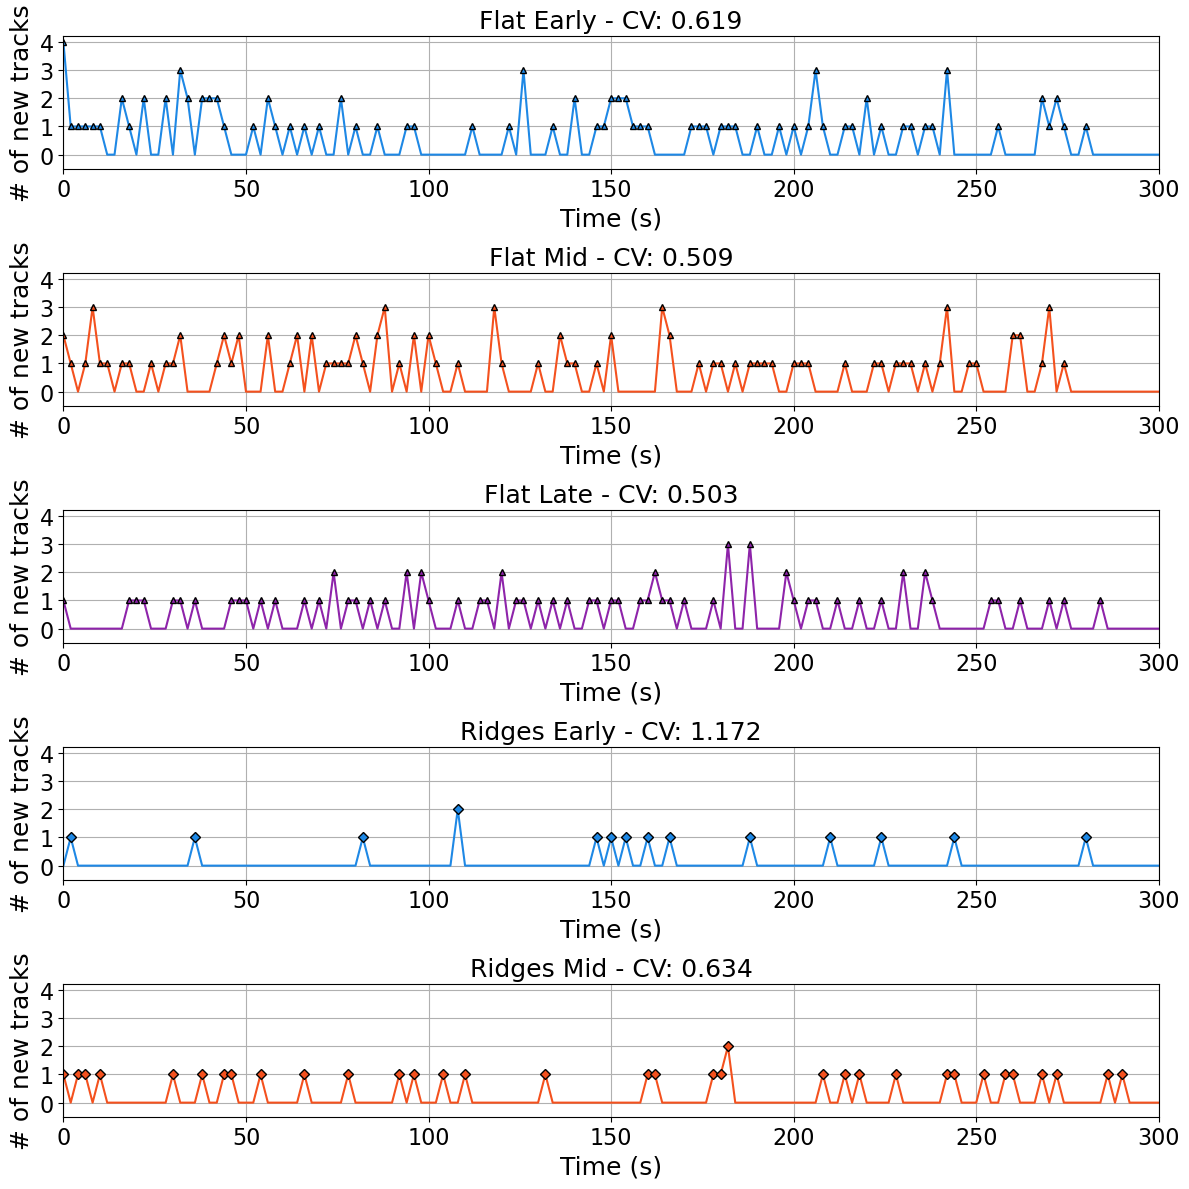

In [455]:
from tifffile import TiffFile

def convert_to_code_path(path):
    # Assuming this is just a placeholder for converting paths to code-friendly format
    return path

def calculate_cv_for_first_appearances(df, num_frames, window_size=10):
    """
    Calculate Coefficient of Variation (CV) for first appearance counts and return the overall CV.
    """
    first_appearances = df.groupby('particle')['frame'].min()
    first_appearance_counts = first_appearances.value_counts().sort_index()

    # Ensure all frames are represented, even those with no first appearance
    all_frames = np.arange(0, num_frames)
    first_appearance_counts_full = pd.Series(0, index=all_frames)
    first_appearance_counts_full.update(first_appearance_counts)

    trajectory_counts_per_frame = first_appearance_counts_full.values

    # Coefficient of Variation (CV) for first appearance counts
    mean_first_appearances = first_appearance_counts_full.mean()
    std_first_appearances = first_appearance_counts_full.std()
    
    if mean_first_appearances != 0:
        cv_first_appearances = std_first_appearances / mean_first_appearances
    else:
        cv_first_appearances = np.nan

    # Calculate CV based on windowed counts
    sum_counts = []
    for start in range(0, len(trajectory_counts_per_frame), window_size):
        end = min(start + window_size, len(trajectory_counts_per_frame))
        sum_counts.append(sum(trajectory_counts_per_frame[start:end]))

    # Calculate the overall CV
    overall_cv = np.std(sum_counts) / np.mean(sum_counts)

    return overall_cv, trajectory_counts_per_frame

def calculate_cv_and_plot(data_folders):
    """
    Calculate and plot the Coefficient of Variation (CV) for particle appearance trajectories for 
    multiple conditions, displayed in subplots.
    
    Parameters:
    data_folders (dict): A dictionary with condition names as keys and folder paths as values
    """
    num_conditions = len(data_folders)  # Number of conditions (5 curves)
    fig, axes = plt.subplots(num_conditions, 1, figsize=(12, 12))  # Create subplots, one below another

    if len(data_folders) == 1:
        axes = [axes]  # To ensure axes is iterable when only one plot is present
    
    # Define colors and markers
    group_colors = ['#1E88E5', '#F4511E', '#8E24AA']  # Colors for early, mid, late
    flat_markers = ["^", "^", "^"]  # Marker for flat surface
    ridges_markers = ["D", "D"]  # Marker for ridged surface

    for i, (condition, data_folder) in enumerate(data_folders.items()):
        # Read the CSV file containing trajectory data
        df = pd.read_csv(os.path.join(data_folder, "tp_trajectories_final.csv"))

        # Search for the .tiff file and get the number of frames
        tiff_files = glob.glob(os.path.join(data_folder, '*_jttr_blch_corr.tiff'))
        if tiff_files:
            tiff_file_path = tiff_files[0]
            with TiffFile(tiff_file_path) as tif:
                num_frames = len(tif.pages)
        else:
            print(f"No '_jttr_blch_corr.tiff' file found in the folder {data_folder}. Skipping.")
            continue

        # Calculate CV for first appearances
        cv_value, trajectory_counts_per_frame = calculate_cv_for_first_appearances(df, num_frames)

        # Assign colors and markers based on the condition
        if 'Flat' in condition:
            if 'Early' in condition:
                color = group_colors[0]  # Blue for early
            elif 'Mid' in condition:
                color = group_colors[1]  # Orange for mid
            elif 'Late' in condition:
                color = group_colors[2]  # Purple for late
            marker = '^'  # Marker for flat conditions (all stages)
        elif 'Ridges' in condition:
            if 'Early' in condition:
                color = group_colors[0]  # Blue for early
            elif 'Mid' in condition:
                color = group_colors[1]  # Orange for mid
            marker = 'D'  # Marker for ridged conditions (all stages)
        

        # Plot the results with the appropriate color and marker, only where counts are non-zero
        non_zero_indices = np.nonzero(trajectory_counts_per_frame)[0]  # Get indices where the values are non-zero
        
        # Plot the trajectory counts for all frames (lines)
        axes[i].plot(np.arange(0, num_frames) * 2, trajectory_counts_per_frame, linestyle="-", color=color)
        
        # Plot markers only at non-zero counts
        axes[i].plot(non_zero_indices * 2, trajectory_counts_per_frame[non_zero_indices], linestyle="", color=color, marker=marker, markersize=5, markeredgecolor='black', markeredgewidth=1.0)

        axes[i].set_ylim([-0.5, 4.2])  # Set y-axis limits (# of new tracks)
        axes[i].set_xlim([0, 300])
        yticks = np.arange(0, 5, 1)
        axes[i].set_yticks(yticks)

        axes[i].set_title(f'{condition} - CV: {cv_value:.3f}', fontsize=18)
        axes[i].set_xlabel('Time (s)', fontsize=18)
        axes[i].set_ylabel('# of new tracks', fontsize=18)
        axes[i].tick_params(axis='both', which='major', labelsize=16)
        axes[i].tick_params(axis='both', which='minor', labelsize=16)

        # Optionally add grid, or other styling
        axes[i].grid(True)

    plt.tight_layout()
    plt.savefig('E:\\Spandan\\2D_Neurons_Paper\\new_tracks_vs_time_demo_flat_ridge.svg', format='svg', bbox_inches='tight')
    plt.show()

# Define the data folders and conditions
data_folders = {
    "Flat Early": convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div5\control_2018_08_24_MAX_40x_Cx_CellLight on DIV3 for48h_488_timelapse1'),
    "Flat Mid": convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2019_01_21_C2_glass+PDL_timelapse2'),
    "Flat Late": convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div23\control_div23_glass_2019_04_22_CortDIV23_+ClDIV17+en_timelapse1b'),
    "Ridges Early": convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div2\ridges_19_02_11_C2_ridges_timelapse4a'),
    "Ridges Mid": convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div8\ridges_2019_02_11_C2_ridges_timelapse1')
}

# Example usage to plot the CV for the five conditions
calculate_cv_and_plot(data_folders)


### Single function calculating CV from a given data-folder

Number of frames in the tiff file: 241


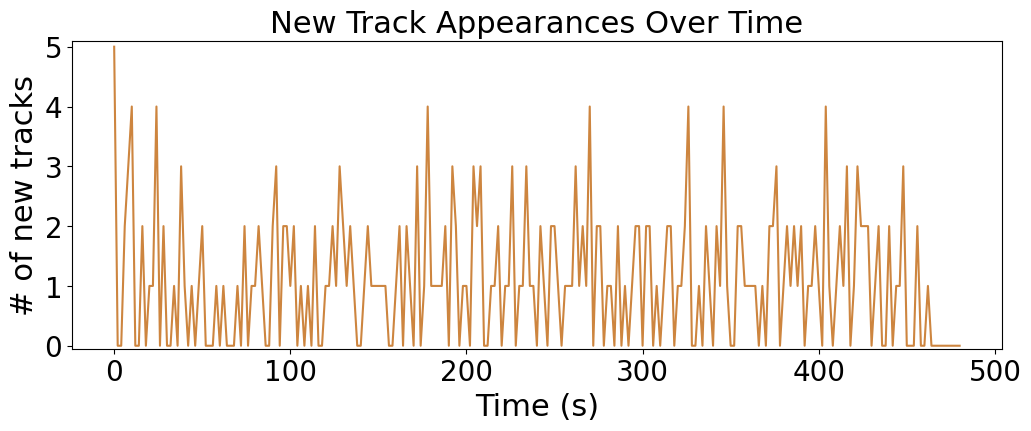

Overall Coefficient of Variation (CV): 0.3822380338209032


In [428]:
def calculate_cv_and_plot(data_folder, plotting_flag=1):
    """
    This function calculates the Coefficient of Variation (CV) for particle appearance trajectories 
    and plots the new track appearances over time.
    
    Parameters:
    data_folder (str): The folder path containing the trajectory data and the TIFF file
    
    Returns:
    float: The Coefficient of Variation (CV)
    """
    # 1. Read the CSV file containing trajectory data
    df = pd.read_csv(os.path.join(data_folder, "tp_trajectories_final.csv"))

    # 2. Search for the .tiff file that ends with '_jttr_blch_corr.tiff'
    tiff_files = glob.glob(os.path.join(data_folder, '*_jttr_blch_corr.tiff'))

    # 3. Read the TIFF file and get the number of frames
    if tiff_files:
        tiff_file_path = tiff_files[0]
        with tiff.TiffFile(tiff_file_path) as tif:
            num_frames = len(tif.pages)
        print(f"Number of frames in the tiff file: {num_frames}")
    else:
        print("No '_jttr_blch_corr.tiff' file found in the folder.")
        return None

    # 4. Calculate burstiness metrics (autocorrelation and CV for first appearances)
    first_appearances = df.groupby('particle')['frame'].min()
    first_appearance_counts = first_appearances.value_counts().sort_index()

    # Ensure all frames are represented, even those with no first appearance
    max_frame = df['frame'].max()
    all_frames = np.arange(0, num_frames)
    first_appearance_counts_full = pd.Series(0, index=all_frames)
    first_appearance_counts_full.update(first_appearance_counts)

    trajectory_counts_per_frame = first_appearance_counts_full.values

    # Autocorrelation for first appearance counts
    if len(trajectory_counts_per_frame) > 1:
        autocorr_first_appearances = np.corrcoef(trajectory_counts_per_frame[:-1], trajectory_counts_per_frame[1:])[0, 1]
    else:
        autocorr_first_appearances = np.nan

    # Coefficient of Variation (CV) for first appearance counts
    mean_first_appearances = first_appearance_counts_full.mean()
    std_first_appearances = first_appearance_counts_full.std()
    
    if mean_first_appearances != 0:
        cv_first_appearances = std_first_appearances / mean_first_appearances
    else:
        cv_first_appearances = np.nan

    # 5. Calculate the overall Coefficient of Variation (CV) based on counts in windows
    window_size = 10
    sum_counts = []

    # Create a list to store the counts in each window
    counts_in_windows = []
    for start in range(0, len(trajectory_counts_per_frame), window_size):
        end = min(start + window_size, len(trajectory_counts_per_frame))
        counts_in_windows.append(trajectory_counts_per_frame[start:end])

    for i in range(len(counts_in_windows)):
        sum_counts.append(sum(counts_in_windows[i]))

    # Calculate the overall CV
    overall_cv = np.std(sum_counts) / np.mean(sum_counts)

    if plotting_flag==1:

        # 6. Plot the first appearance counts over time
        time_axis = np.arange(0, num_frames, 1) * 2  # Multiply by frame interval
    
        plt.figure(figsize=(12, 4))
        plt.plot(time_axis, trajectory_counts_per_frame, linestyle="-", color="peru")
    
        yticks = np.arange(0, 6, 1)
        plt.yticks(yticks)
        plt.ylim([-0.05, 5.1])
        plt.xlabel('Time (s)', fontsize=22)
        plt.ylabel('# of new tracks', fontsize=22)
        plt.title('New Track Appearances Over Time', fontsize=22)
        plt.tick_params(axis='both', which='major', labelsize=20)
        plt.tick_params(axis='both', which='minor', labelsize=20)
    
        # Save the plot
        plt.savefig(os.path.join(data_folder, 'new_tracks_vs_time_demo_ridge.svg'), format='svg', bbox_inches='tight')
        plt.show()
    
    return overall_cv

# Example usage:
data_folder = r'E:\Spandan\2D_Neurons_Paper\Glass\div17\control_2019_02_11_Cort_DIV17_plate1_timelapse2'
cv_value = calculate_cv_and_plot(data_folder)
print(f"Overall Coefficient of Variation (CV): {cv_value}")


In [415]:
def calculate_tracks_per_minute_simple(data_folders):
    """
    Calculate the total number of tracks per 1 minute (60 seconds) for each condition.
    
    Parameters:
    data_folders (dict): A dictionary with condition names as keys and folder paths as values
    """
    total_tracks_per_minute = {}  # Dictionary to hold total tracks per minute for each condition
    
    for condition, data_folder in data_folders.items():
        # Read the CSV file containing trajectory data
        df = pd.read_csv(os.path.join(data_folder, "tp_trajectories_final.csv"))
        
        # Search for the .tiff file and get the number of frames
        tiff_files = glob.glob(os.path.join(data_folder, '*_jttr_blch_corr.tiff'))
        if tiff_files:
            tiff_file_path = tiff_files[0]
            with tiff.TiffFile(tiff_file_path) as tif:
                num_frames = len(tif.pages)
        else:
            print(f"No '_jttr_blch_corr.tiff' file found in the folder {data_folder}. Skipping.")
            continue
        
        # Convert frames to seconds (assuming 2 seconds per frame)
        frames_per_minute = 60 / 2  # 1 minute = 60 seconds, and each frame corresponds to 2 seconds
        
        # Calculate the total number of minutes (duration)
        duration_minutes = num_frames * 2 / 60  # Convert frames to minutes
        
        # Count the total number of unique trajectories
        total_trajectories = df['particle'].nunique()
        
        # Calculate tracks per minute
        tracks_per_minute = total_trajectories / duration_minutes
        total_tracks_per_minute[condition] = tracks_per_minute
    
    return total_tracks_per_minute

# Example usage
data_folders = {
    "Flat Early": convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div5\control_2018_08_24_MAX_40x_Cx_CellLight on DIV3 for48h_488_timelapse1'),
    "Flat Mid": convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2019_01_21_C2_glass+PDL_timelapse2'),
    "Flat Late": convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div23\control_div23_glass_2019_04_22_CortDIV23_+ClDIV17+en_timelapse1b'),
    "Ridges Early": convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div2\ridges_19_02_11_C2_ridges_timelapse4a'),
    "Ridges Mid": convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div8\ridges_2019_02_11_C2_ridges_timelapse1')
}

# Get total tracks per minute
total_tracks_per_minute = calculate_tracks_per_minute_simple(data_folders)

# Print the results
for condition, track_count in total_tracks_per_minute.items():
    print(f"Condition: {condition}, Tracks per minute: {track_count}")


Condition: Flat Early, Tracks per minute: 18.675496688741724
Condition: Flat Mid, Tracks per minute: 19.47019867549669
Condition: Flat Late, Tracks per minute: 14.304635761589404
Condition: Ridges Early, Tracks per minute: 2.7906976744186047
Condition: Ridges Mid, Tracks per minute: 5.282392026578073


In [422]:
def mask_size(data_folder, resolution):
    """
    Calculate the number of non-NaN pixels in a neural mask.

    Parameters:
    - data_folder (str): Path to the folder containing the 'neural_mask.mat' file.
    - resolution (float): Resolution to scale the pixel count (e.g., micrometers per pixel).

    Returns:
    - float: Number of non-NaN pixels scaled by the given resolution.
    """
    mask_path = os.path.join(data_folder, 'neural_mask.mat')
    if not os.path.exists(mask_path):
        raise FileNotFoundError(f"Mask file not found at: {mask_path}")
    
    mask = sio.loadmat(mask_path)['neural_mask']
    mask = mask.astype(float)
    mask[mask == 0] = np.NaN
    
    non_nan_pixels = np.count_nonzero(~np.isnan(mask))
    
    scaled_size = non_nan_pixels / (resolution ** 2)
    
    return scaled_size

def calculate_tracks_per_minute_simple(data_folders, resolution=1.0):
    """
    Calculate the total number of tracks per 1 minute (60 seconds) and normalized tracks per minute for each condition.
    
    Parameters:
    data_folders (dict): A dictionary with condition names as keys and folder paths as values
    resolution (float): Resolution for normalizing the tracks per minute based on the neural mask size.
    """
    total_tracks_per_minute = {}  # Dictionary to hold total tracks per minute for each condition
    normalized_tracks_per_minute = {}  # Dictionary to hold normalized tracks per minute for each condition
    
    for condition, data_folder in data_folders.items():
        # Read the CSV file containing trajectory data
        df = pd.read_csv(os.path.join(data_folder, "tp_trajectories_final.csv"))
        
        # Search for the .tiff file and get the number of frames
        tiff_files = glob.glob(os.path.join(data_folder, '*_jttr_blch_corr.tiff'))
        if tiff_files:
            tiff_file_path = tiff_files[0]
            with tiff.TiffFile(tiff_file_path) as tif:
                num_frames = len(tif.pages)
        else:
            print(f"No '_jttr_blch_corr.tiff' file found in the folder {data_folder}. Skipping.")
            continue
        
        # Convert frames to seconds (assuming 2 seconds per frame)
        frames_per_minute = 60 / 2  # 1 minute = 60 seconds, and each frame corresponds to 2 seconds
        
        # Calculate the total number of minutes (duration)
        duration_minutes = num_frames * 2 / 60  # Convert frames to minutes
        
        # Count the total number of unique trajectories
        total_trajectories = df['particle'].nunique()
        
        # Calculate tracks per minute
        tracks_per_minute = total_trajectories / duration_minutes
        
        # Get the mask size for normalization
        try:
            mask_area = mask_size(data_folder, resolution)
            normalized_tracks_per_minute[condition] = tracks_per_minute*400 / mask_area
        except FileNotFoundError:
            print(f"Mask not found for condition {condition}. Normalization skipped.")
            normalized_tracks_per_minute[condition] = np.nan  # If mask is not found, set NaN
        
        total_tracks_per_minute[condition] = tracks_per_minute
    
    return total_tracks_per_minute, normalized_tracks_per_minute

# Example usage
data_folders = {
    "Flat Early": r'E:\Spandan\2D_Neurons_Paper\Glass\div5\control_2018_08_24_MAX_40x_Cx_CellLight on DIV3 for48h_488_timelapse1',
    "Flat Mid": r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2019_01_21_C2_glass+PDL_timelapse2',
    "Flat Late": r'E:\Spandan\2D_Neurons_Paper\Glass\div23\control_div23_glass_2019_04_22_CortDIV23_+ClDIV17+en_timelapse1b',
    "Ridges Early": r'E:\Spandan\2D_Neurons_Paper\Ridges\div2\ridges_19_02_11_C2_ridges_timelapse4a',
    "Ridges Mid": r'E:\Spandan\2D_Neurons_Paper\Ridges\div8\ridges_2019_02_11_C2_ridges_timelapse1'
}

# Resolution in micrometers per pixel
resolution = 2.7778

# Get total and normalized tracks per minute
tracks_per_min, normtracks_per_min = calculate_tracks_per_minute_simple(data_folders, resolution=resolution)

# Print the results for each condition
print("Condition\tTotal Tracks per Minute\tNormalized Tracks per Minute")
for condition in data_folders.keys():
    total_tracks = tracks_per_min.get(condition, "N/A")
    normalized_tracks = normtracks_per_min.get(condition, "N/A")
    print(f"{condition}\t{total_tracks:.2f}\t{normalized_tracks:.2f}")


Condition	Total Tracks per Minute	Normalized Tracks per Minute
Flat Early	18.68	6.67
Flat Mid	19.47	7.46
Flat Late	14.30	4.69
Ridges Early	2.79	2.57
Ridges Mid	5.28	2.39
